In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-09-24 17:13:02.834370: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-09-24 17:13:04.254163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-09-24 17:13:04.254383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-09-24 17:13:04.255672: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-09-24 17:13:04.256830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-09-24 17:13:04.257111: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-09-24 17:13:04.258517: I tensorflow/stream_executor

In [178]:
mean_1 = [0, 0, 0]
cov_1 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

mean_2 = [1, 1, 1]
cov_2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)

In [179]:
print(x_1[0])

[0.05116696 1.13842339 1.10984764]


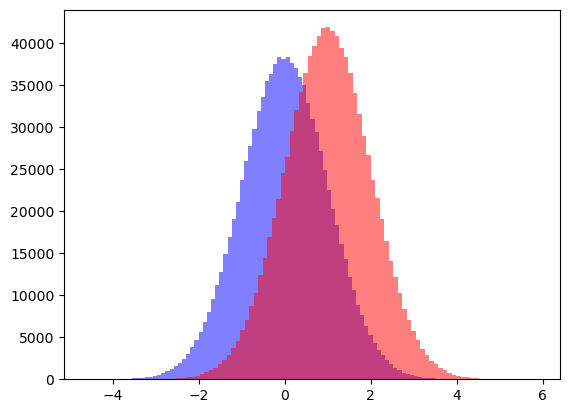

In [180]:
plt.hist(y_1[:,1], alpha = 0.5, bins = 100, color = 'b')
plt.hist(y_2[:,1], alpha = 0.5, bins = 100, color = 'r')
plt.show()

In [181]:
n_sig = 10000
n_bkg = 500

#x_2 means signal and x_1 means background
x_sig_1 = x_1[0:250000]
true_label_sig_1 = np.zeros_like(x_sig_1[:,0])
x_sig_2 = x_2[0:n_sig]
true_label_sig_2 = np.ones_like(x_sig_2[:,0])
x_bkg_1 = x_1[250000:(500000+n_sig-n_bkg)]
true_label_bkg_1 = np.zeros_like(x_bkg_1[:,0])
x_bkg_2 = x_2[0:500]
true_label_bkg_2 = np.ones_like(x_bkg_2[:,0])

In [182]:
rng = np.random.default_rng()
x_sig = np.concatenate((x_sig_1, x_sig_2))
x_bkg = np.concatenate((x_bkg_1, x_bkg_2))
true_label_sig = np.concatenate((true_label_sig_1, true_label_sig_2))
true_label_bkg = np.concatenate((true_label_bkg_1, true_label_bkg_2))

indices_sig = rng.permutation(np.shape(x_sig)[0])
indices_bkg = rng.permutation(np.shape(x_bkg)[0])


x_sig = x_sig[indices_sig]
true_label_sig = true_label_sig[indices_sig]

x_bkg = x_bkg[indices_bkg]
true_label_bkg = true_label_bkg[indices_bkg]

In [183]:
print(true_label_sig)

[0. 0. 0. ... 0. 0. 1.]


In [184]:
print(np.shape(x_sig))

(260000, 3)


In [185]:
print(np.shape(x_sig[true_label_sig == 0.]))

(250000, 3)


In [186]:
print(np.shape(x_sig), np.shape(x_bkg))

(260000, 3) (260000, 3)


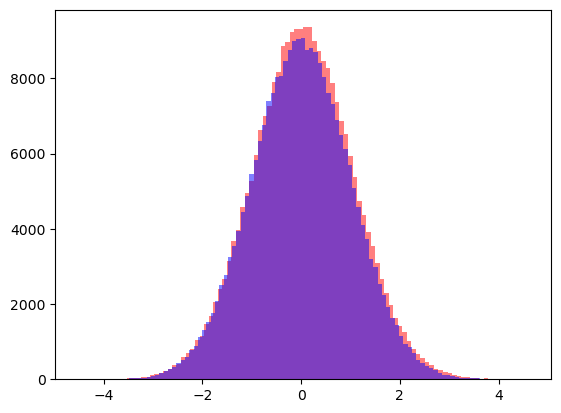

In [187]:
plt.hist(x_sig[:,0], alpha = 0.5, bins = 100, color = 'r')
plt.hist(x_bkg[:,0], alpha = 0.5, bins = 100, color = 'b')
plt.show()

Without bootstrapping

In [188]:
def CWoLA():
    input_1 = keras.layers.Input(shape = (3))
    dnn = keras.Sequential([
          keras.layers.Dense(32, activation = 'relu'),
          keras.layers.Dense(16, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    x = dnn(input_1)
    return keras.Model(         
    inputs=[input_1],
    outputs=x,)

In [189]:
print(np.shape(x_bkg))

(260000, 3)


In [190]:
y_sig = np.ones(np.shape(x_sig)[0])
y_bkg = np.zeros(np.shape(x_bkg)[0])

y_train = np.concatenate((y_sig, y_bkg))
x_train = np.concatenate((x_sig, x_bkg))
true_label_train = np.concatenate((true_label_sig, true_label_bkg))

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]

cwola = CWoLA()
loss_object = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
cwola.fit(x_train, y_train, validation_split = 0.2,
        shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 10)  

Train on 416000 samples, validate on 104000 samples
Epoch 1/10
416000/416000 [==============================] - 4s 9us/sample - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6923 - val_accuracy: 0.5102
Epoch 2/10
416000/416000 [==============================] - 3s 8us/sample - loss: 0.6923 - accuracy: 0.5101 - val_loss: 0.6921 - val_accuracy: 0.5115
Epoch 3/10
416000/416000 [==============================] - 3s 8us/sample - loss: 0.6922 - accuracy: 0.5111 - val_loss: 0.6921 - val_accuracy: 0.5128
Epoch 4/10
416000/416000 [==============================] - 3s 8us/sample - loss: 0.6922 - accuracy: 0.5111 - val_loss: 0.6921 - val_accuracy: 0.5128
Epoch 5/10
416000/416000 [==============================] - 3s 8us/sample - loss: 0.6921 - accuracy: 0.5114 - val_loss: 0.6921 - val_accuracy: 0.5123
Epoch 6/10
416000/416000 [==============================] - 3s 8us/sample - loss: 0.6921 - accuracy: 0.5114 - val_loss: 0.6921 - val_accuracy: 0.5129
Epoch 7/10
416000/416000 [======================

In [191]:
x_test = np.concatenate((y_1, y_2))

y_test_sig = np.ones(np.shape(y_2)[0])
y_test_bkg = np.zeros(np.shape(y_1)[0])
y_test = np.concatenate((y_test_bkg, y_test_sig))

In [192]:
x_predict = cwola.predict(x_test)

In [193]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


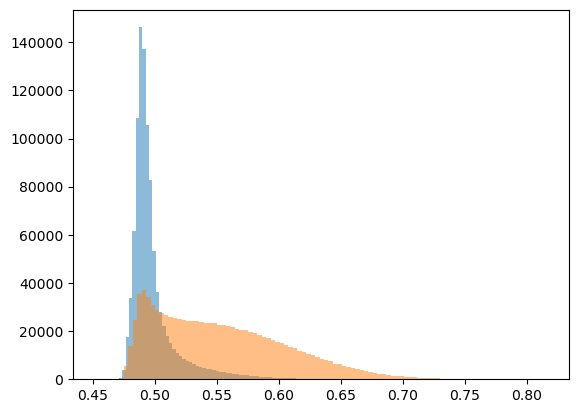

In [194]:
plt.hist(x_predict_0, bins = 100, alpha = 0.5)
plt.hist(x_predict_1, bins = 100, alpha = 0.5)
plt.show()

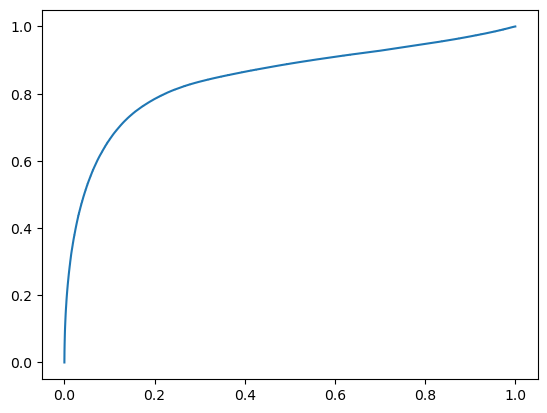

0.8462234751135002


In [195]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

With bootstrapping

In [196]:
y_sig = np.ones(np.shape(x_sig)[0])
y_bkg = np.zeros(np.shape(x_bkg)[0])

y_train = np.concatenate((y_sig, y_bkg))
x_train = np.concatenate((x_sig, x_bkg))
true_label_train = np.concatenate((true_label_sig, true_label_bkg))

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]

cwola_2 = CWoLA()
loss_object = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
cwola_2.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
for i in range(3):
    cwola_2.fit(x_train, y_train, validation_split = 0.2,
            shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 2)  
    
    predict = (cwola_2.predict(x_train)).flatten()
    
    predict_array = np.zeros_like(y_train)
    predict_array[predict >= np.percentile(predict, 99)] = 1
    y_train = predict_array
    print(y_train)
    

Train on 416000 samples, validate on 104000 samples
Epoch 1/2
416000/416000 [==============================] - 4s 9us/sample - loss: 0.6937 - accuracy: 0.5050 - val_loss: 0.6925 - val_accuracy: 0.5129
Epoch 2/2
416000/416000 [==============================] - 3s 8us/sample - loss: 0.6924 - accuracy: 0.5087 - val_loss: 0.6924 - val_accuracy: 0.5112
[0. 0. 0. ... 0. 0. 0.]
Train on 416000 samples, validate on 104000 samples
Epoch 1/2
416000/416000 [==============================] - 3s 7us/sample - loss: 0.1882 - accuracy: 0.9857 - val_loss: 0.0704 - val_accuracy: 0.9902
Epoch 2/2
416000/416000 [==============================] - 3s 7us/sample - loss: 0.0529 - accuracy: 0.9900 - val_loss: 0.0394 - val_accuracy: 0.9902
[0. 0. 0. ... 0. 0. 0.]
Train on 416000 samples, validate on 104000 samples
Epoch 1/2
416000/416000 [==============================] - 3s 7us/sample - loss: 0.0284 - accuracy: 0.9901 - val_loss: 0.0228 - val_accuracy: 0.9910
Epoch 2/2
416000/416000 [==========================

In [197]:
x_predict = cwola_2.predict(x_test)

In [198]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

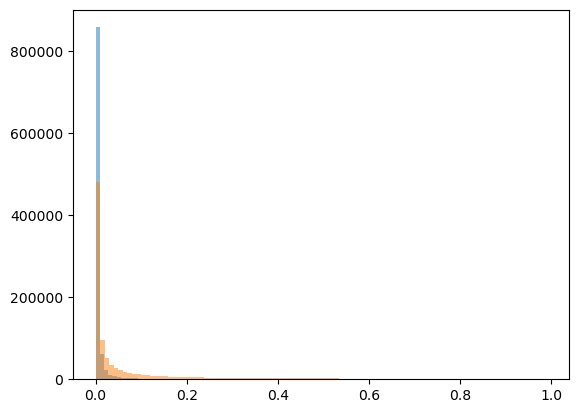

In [199]:
plt.hist(x_predict_0, bins = 100, alpha = 0.5)
plt.hist(x_predict_1, bins = 100, alpha = 0.5)
plt.show()

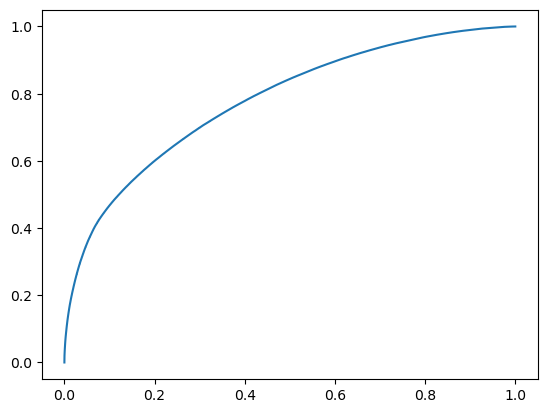

0.7786520708105


In [200]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [201]:
print(epsilon_s)

[0.041969 0.155039 0.467208]
